In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

### Sei Stats for Training Data

In [2]:
sei_scores = pd.read_csv("/n/groups/marks/users/courtney/projects/regulatory_genomics/models/LOL-EVE_private/data/data_june/raw_rc_fw_with_scores.csv")

In [3]:
# print(sei_scores.species.head())
sei_scores_human = sei_scores[sei_scores.species == 'homo_sapiens']

In [3]:
sei_scores.score.mean()

5.487837423675456

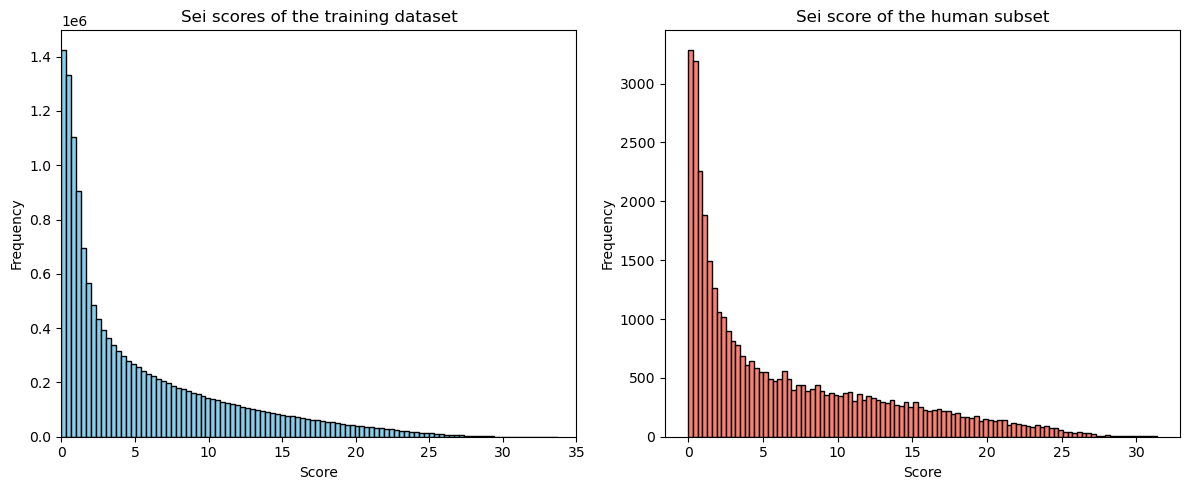

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5)) # nrows=1, ncols=2 means 1 row, 2 columns

# Plot the first histogram on the left subplot (axes[0])
axes[0].hist(sei_scores.score, bins=100, color='skyblue', edgecolor='black')
axes[0].set_title('Sei scores of the training dataset')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 35) # Set x-axis limits


# Plot the second histogram on the right subplot (axes[1])
axes[1].hist(sei_scores_human.score, bins=100, color='salmon', edgecolor='black')
axes[1].set_title('Sei score of the human subset')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Frequency')
axes[0].set_xlim(0, 35) # Set x-axis limits


# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

### Load Generated Promoters

In [2]:
# path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/1k_val_big_greedy_mid_temp_generated_promoters.csv"
path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/new_all_human_16k_context_big_greedy_mid_temp_generated_promoters.csv"
# path = '/n/groups/marks/users/erik/Promoter_Poet_private/data/60_big_human_token_16k_context_small_greedy_mid_temp_generated_promoters.csv'
# path = '/n/groups/marks/users/erik/Promoter_Poet_private/data/human_token_16k_context_small_greedy_mid_temp_generated_promoters.csv'
# path = '/n/groups/marks/users/erik/Promoter_Poet_private/data/new_human_token_16k_context_small_greedy_mid_temp_generated_promoters.csv'
# path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/latest_small_human_token_16k_context_small_greedy_mid_temp_generated_promoters.csv"
# path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/mid_latest_60_big_human_token_16k_context_small_greedy_mid_temp_generated_promoters.csv"
# path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/val_big_random_low_temp_generated_promoters.csv"
# path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/high_latest_60_big_human_token_16k_context_small_greedy_mid_temp_generated_promoters.csv"
# path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/16k_latest_60_big_human_token_16k_context_small_greedy_mid_temp_generated_promoters.csv"
# path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/lower_latest_60_big_human_token_16k_context_small_greedy_mid_temp_generated_promoters.csv"
# path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/mid_latest_60_big_human_token_16k_context_small_greedy_mid_temp_generated_promoters.csv"
# path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/long_latest_60_big_human_token_16k_context_small_greedy_mid_temp_generated_promoters.csv"
path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/single_seq_16k_context_big_greedy_mid_temp_generated_promoters.csv"
df = pd.read_csv(path)
seqs = [] 

for i, row in df.iterrows():
    s = row.samples
    seqs.extend(s[1:-1].split(','))
    


In [40]:
# remove duplicates and premature termination

seqs = list(filter(lambda x: x, map(lambda x: x[1:-1], seqs)))
seqs = list(set(seqs))
seqs = [s[:1000] for s in seqs if len(s) > 800]
print(len(seqs))



In [15]:
# convert to fasta for sei scoring
import textwrap

def write_fasta_file(sequences, identifiers=None, filename="/n/groups/marks/users/erik/Promoter_Poet_private/data/rand.fasta"):
    """
    Converts a list of DNA sequence strings into a FASTA file.

    Args:
        sequences (list): A list of strings, where each string is a DNA sequence.
        identifiers (list, optional): A list of strings, where each string is
                                      an identifier for the corresponding sequence.
                                      If None, simple identifiers (e.g., seq_1, seq_2)
                                      will be generated. Defaults to None.
        filename (str, optional): The name of the output FASTA file.
                                  Defaults to "output.fasta".
    """
    if identifiers is None:
        # Generate simple identifiers if none are provided
        identifiers = [f"seq_{i+1}" for i in range(len(sequences))]
    elif len(identifiers) != len(sequences):
        # Check if the number of identifiers matches the number of sequences
        print("Warning: Number of identifiers does not match the number of sequences.")
        print("Generating simple identifiers instead.")
        identifiers = [f"seq_{i+1}" for i in range(len(sequences))]

    try:
        with open(filename, "w") as f:
            for i, sequence in enumerate(sequences):
                # Write the identifier line
                f.write(f">{identifiers[i]}\n")
                wrapped_sequence = textwrap.fill(sequence, width=60)
                f.write(wrapped_sequence + "\n")

        print(f"Successfully wrote {len(sequences)} sequences to {filename}")

    except IOError as e:
        print(f"Error writing to file {filename}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

write_fasta_file(seqs)

Successfully wrote 2748 sequences to /n/groups/marks/users/erik/Promoter_Poet_private/data/rand.fasta


### Process results of Sei (use sei.sh)

In [2]:
# result = "/n/groups/marks/users/erik/Promoter_Poet_private/sei/30.raw_sequence_class_scores.npy"
# result = "/n/groups/marks/users/erik/Promoter_Poet_private/sei/new_60.raw_sequence_class_scores.npy"
result = "/n/groups/marks/users/erik/Promoter_Poet_private/sei/rand.raw_sequence_class_scores.npy"
res = np.load(result)

(2748, 61)
25


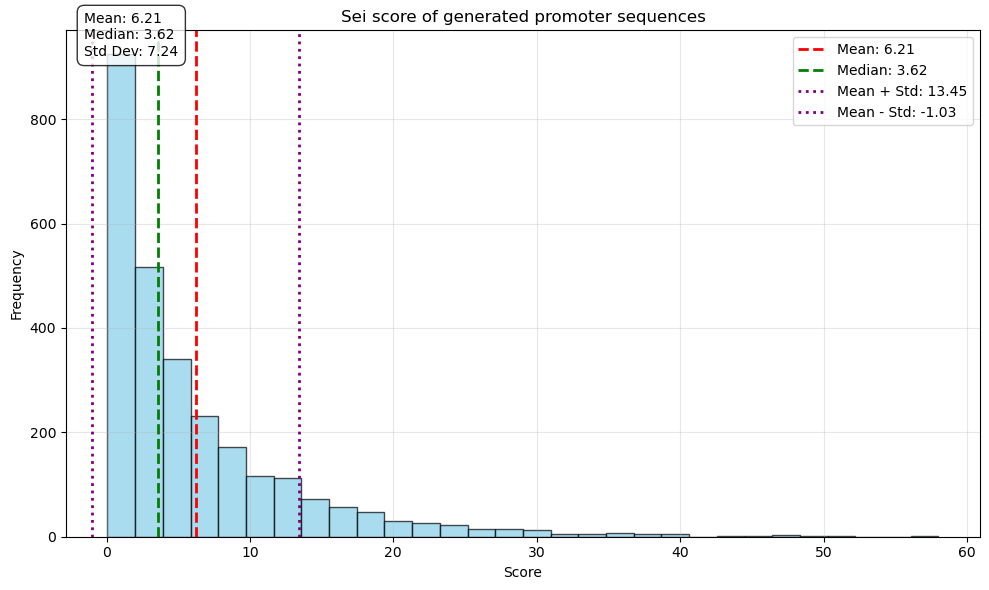

In [4]:
print(res.shape)
P = res.mean(axis=0).argmax()
print(P) # 25

data = res[:, P]
mean_val = np.mean(data)
median_val = np.median(data)
std_val = np.std(data)

# Create the histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')

# Add vertical lines for mean, median and std
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')

# Add vertical lines at mean±std
plt.axvline(mean_val + std_val, color='purple', linestyle='dotted', linewidth=2, label=f'Mean + Std: {mean_val + std_val:.2f}')
plt.axvline(mean_val - std_val, color='purple', linestyle='dotted', linewidth=2, label=f'Mean - Std: {mean_val - std_val:.2f}')

# Add labels and title
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Sei score of generated promoter sequences')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text with statistics information
stats_text = f"Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd Dev: {std_val:.2f}"
plt.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# Load human promoters (optionally only chr 19, or include mammals)

In [8]:
q_path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/query.pkl"
with open(q_path, "rb") as f:
    queries = pickle.load(f)
    
# h_path = "/n/groups/marks/users/erik/Promoter_Poet_private/data/hits.pkl"
# with open(h_path, "rb") as f:
#     hits = pickle.load(f)
# queries = []
# for val in hits.values():
#     queries.extend(list(val))
    
# queries = [v for k, v in queries.items() if k.endswith('_chr19')]
    
queries = list(queries.values())
print(len(queries))

19228


In [27]:
import random 

def hamming_distance(seq1, seq2):
    """Calculate the Hamming distance between two sequences, truncating the longer one if necessary."""
    # Truncate the longer sequence to match the length of the shorter one
    min_length = min(len(seq1), len(seq2))
    seq1_trunc = seq1[:min_length]
    seq2_trunc = seq2[:min_length]
    
    # Calculate Hamming distance on the truncated sequences
    return sum(ch1 != ch2 for ch1, ch2 in zip(seq1_trunc, seq2_trunc))

def average_hamming_distance(seq, comparison_sequences):
    """Calculate the average Hamming distance between a sequence and a set of sequences."""
    if not comparison_sequences:
        return 0
    
    # Calculate Hamming distance for all comparison sequences
    total_distance = sum(hamming_distance(seq, comp_seq) for comp_seq in comparison_sequences)
    return total_distance / len(comparison_sequences)

def plot_score_vs_hamming(sequences, scores, comparison_sequences):
    """Plot scores vs average Hamming distances."""
    avg_distances = []
    valid_scores = []
    valid_sequences = []
    
    for i, (seq, score) in tqdm(enumerate(zip(sequences, scores)), total=len(sequences)):
        
        avg_dist = average_hamming_distance(seq, comparison_sequences)
        avg_distances.append(avg_dist)
        valid_scores.append(score)
        valid_sequences.append(seq)
    return avg_distances, valid_scores, valid_sequences
        

avg_distances, valid_scores, valid_sequences = plot_score_vs_hamming(seqs, res[:, P], queries)



100%|██████████| 5496/5496 [10:13<00:00,  8.96it/s]


/home/jix836/.conda/envs/promoet/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jix836/.conda/envs/promoet/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jix836/.conda/envs/promoet/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jix836/.conda/envs/promoet/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future

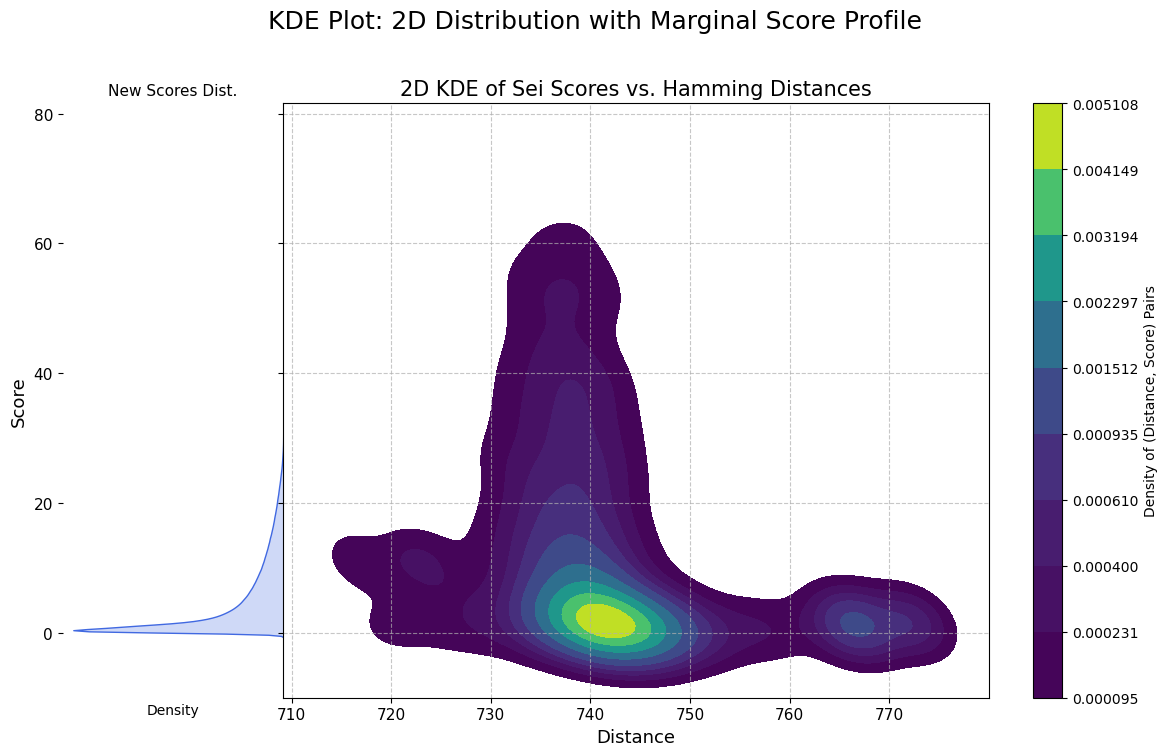

In [31]:
import seaborn as sns
import matplotlib.gridspec as gridspec # For advanced subplot layout

distances = avg_distances

scores_2d = valid_scores

data_2d = pd.DataFrame({
    'distance': distances,
    'score': scores_2d
})

scores_marginal_y = sei_scores_human.score

marginal_y_series = pd.Series(scores_marginal_y, name="marginal_score")
fig = plt.figure(figsize=(12, 8)) # Adjusted figure size for better layout

gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 4], wspace=0, figure=fig) # MODIFIED: wspace=0

# Create subplots based on the GridSpec
ax_marg_y = fig.add_subplot(gs[0, 0])  # Y-marginal KDE on the left
ax_joint = fig.add_subplot(gs[0, 1], sharey=ax_marg_y) # Main 2D KDE on the right, sharing y-axis

# Hide y-tick labels on the main plot to avoid redundancy
plt.setp(ax_joint.get_yticklabels(), visible=False)
plt.setp(ax_joint.get_yaxis().get_offset_text(), visible=False)


sns.kdeplot(
    y=marginal_y_series,
    ax=ax_marg_y,
    color="royalblue",
    fill=True
)
ax_marg_y.set_title('Human Scores Dist.', fontsize=11)
ax_marg_y.set_ylabel('Score', fontsize=13) # Shared y-axis label
ax_marg_y.tick_params(axis='y', labelsize=11) # Y-ticks for shared axis

ax_marg_y.set_xticks([])
# ax_marg_y.tick_params(axis='x', labelrotation=45, labelsize=9) # REMOVED

ax_marg_y.invert_xaxis() # KDE "points" towards the main plot

# ax_marg_y.grid(True, linestyle=':', alpha=0.6, axis='x') 

ax_marg_y.spines['top'].set_visible(False)
ax_marg_y.spines['right'].set_visible(False)
ax_marg_y.spines['bottom'].set_visible(False)
ax_marg_y.spines['left'].set_visible(False)


kde_main_plot = sns.kdeplot(
    data=data_2d,
    x='distance',
    y='score',
    cmap="viridis",
    # fill=True,
    thresh=0.05,
    levels=10,
    cbar=True,
    cbar_kws={'label': 'Density of (Distance, Score) Pairs'},
    ax=ax_joint
)
# ax_joint.set_xlim(725, 755)
ax_joint.set_title('2D KDE of Sei Scores vs. Hamming Distances', fontsize=15)
ax_joint.set_xlabel('Distance', fontsize=13)
ax_joint.tick_params(axis='x', labelsize=11)
ax_joint.grid(True, linestyle='--', alpha=0.7)


# --- 6. Overall Plot Customization ---
fig.suptitle('KDE Plot: 2D Distribution with Marginal Score Profile', fontsize=18, y=0.96)
plt.tight_layout(rect=[0, 0.02, 1, 0.94]) # Adjust rect if suptitle is clipped

# Show the plot
plt.show()

In [5]:
def calculate_nucleotide_proportions(sequences, window=600):
        """Calculate position-specific nucleotide proportions around sequence center"""
        center = len(sequences[0]) // 2
        half_window = window // 2
        positions = range(-half_window, half_window)
        
        # Initialize data structure
        proportions = {
            'A': np.zeros(window),
            'C': np.zeros(window),
            'G': np.zeros(window),
            'T': np.zeros(window)
        }
        
        # Count nucleotides at each position
        for sequence in sequences:
            for i, pos in enumerate(range(center - half_window, center + half_window)):
                if 0 <= pos < len(sequence):
                    nucleotide = sequence[pos]
                    if nucleotide in proportions:
                        proportions[nucleotide][i] += 1
        
        # Convert to proportions
        total = len(sequences)
        for nucleotide in proportions:
            proportions[nucleotide] = proportions[nucleotide] / total
            
        return proportions, positions

In [45]:
model, _ = calculate_nucleotide_proportions(seqs)
gt, _ = calculate_nucleotide_proportions(queries)

In [46]:
# compute the mean delta
total = 0
print(model['A'].shape)
for i in model.keys():
    print(i)
    total += np.abs((model[i] - gt[i])).mean()
print(total / 4) # DELTA

(600,)
A
C
G
T
0.02447918716511394


In [32]:
def plot_nucleotide_proportions(ref_proportions, model_proportions, positions):
        """
        Plot nucleotide proportions (similar to panel b)
        """
        plt.figure(figsize=(10, 8))
        
        # Plot model sequences
        plt.subplot(2, 1, 1)
        for nucleotide, props in model_proportions.items():
            color = {'A': 'green', 'C': 'blue', 'G': 'orange', 'T': 'red'}.get(nucleotide, 'black')
            plt.plot(positions, props, color=color, label=nucleotide)
        plt.title('Model-designed sequence (chr 19)')
        plt.ylabel('Nucleotide proportion')
        plt.ylim(0, 0.6)
        plt.legend()
        
        # Plot reference sequences
        plt.subplot(2, 1, 2)
        for nucleotide, props in ref_proportions.items():
            color = {'A': 'green', 'C': 'blue', 'G': 'orange', 'T': 'red'}.get(nucleotide, 'black')
            plt.plot(positions, props, color=color, label=nucleotide)
        plt.title('Human genome sequence (chr 19)')
        plt.xlabel('Position (basepair to center)')
        plt.ylabel('Nucleotide proportion')
        plt.ylim(0, 0.6)
        plt.legend()
        
        plt.tight_layout()
        return plt.gcf()

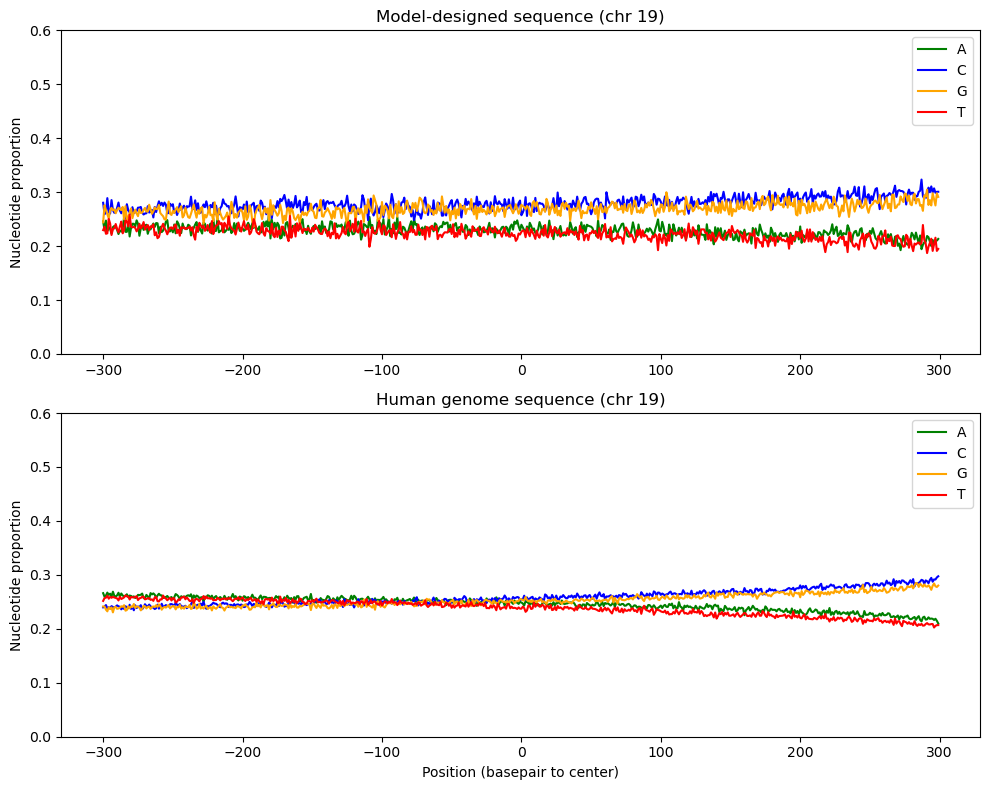

In [22]:
fig = plot_nucleotide_proportions(gt, model, range(-300, 300))
plt.show()

In [23]:
import re
motifs = {
     
            "TATA-box": re.compile("TATA[AT]A[AT]"),
            "GC-box": re.compile("GGGCGG"),
            "CCAAT-box": re.compile("CCAAT")
        }
def calculate_motif_frequency(sequences, window=1000):
        """Calculate motif frequency across positions"""
        center = len(sequences[0]) // 2
        half_window = window // 2
        bins = np.arange(-half_window, half_window + 1, 10)  # 10bp bins
        
        # Initialize data structure
        motif_counts = {motif: np.zeros(len(bins)-1) for motif in motifs}
        
        # Count motifs in each position bin
        for  sequence in sequences:
            for motif_name, motif_pattern in motifs.items():
                for match in motif_pattern.finditer(sequence):
                    # Calculate center position of the motif
                    motif_center = match.start() + len(match.group()) // 2
                    # Position relative to sequence center
                    relative_pos = motif_center - center
                    
                    # Find the bin
                    if -half_window <= relative_pos < half_window:
                        bin_idx = np.digitize(relative_pos, bins) - 1
                        if 0 <= bin_idx < len(motif_counts[motif_name]):
                            motif_counts[motif_name][bin_idx] += 1
        
        # Convert to frequency (normalize by number of sequences and bin width)
        for motif in motif_counts:
            motif_counts[motif] = motif_counts[motif] / (len(sequences) * 10)
            
        return motif_counts, bins[:-1] + 5

In [24]:
def plot_motif_frequency(ref_motifs, model_motifs, bin_centers):
        """
        Plot motif frequency distributions (similar to panel c)
        """
        plt.figure(figsize=(12, 8))
        motif_names = list(ref_motifs.keys())
        colors = ['red', 'orange', 'green']
        
        # Plot motifs for model sequences
        for i, motif in enumerate(motif_names):
            plt.subplot(2, 3, i+1)
            plt.plot(bin_centers, model_motifs[motif], color=colors[i])
            max_val = max(model_motifs[motif].max(), ref_motifs[motif].max()) * 1.1
            plt.ylim(0, max_val)
            if i == 0:
                plt.title("Model-designed sequence\n" + motif)
            else:
                plt.title(motif)
            plt.xlabel("Position (basepair to center)")
            plt.ylabel("Motif frequency")
        
        # Plot motifs for reference sequences
        for i, motif in enumerate(motif_names):
            plt.subplot(2, 3, i+4)
            plt.plot(bin_centers, ref_motifs[motif], color=colors[i])
            max_val = max(model_motifs[motif].max(), ref_motifs[motif].max()) * 1.1
            plt.ylim(0, max_val)
            if i == 0:
                plt.title("Human genome sequence\n" + motif)
            else:
                plt.title(motif)
            plt.xlabel("Position (basepair to center)")
            plt.ylabel("Motif frequency")
        
        plt.tight_layout()
        return plt.gcf()

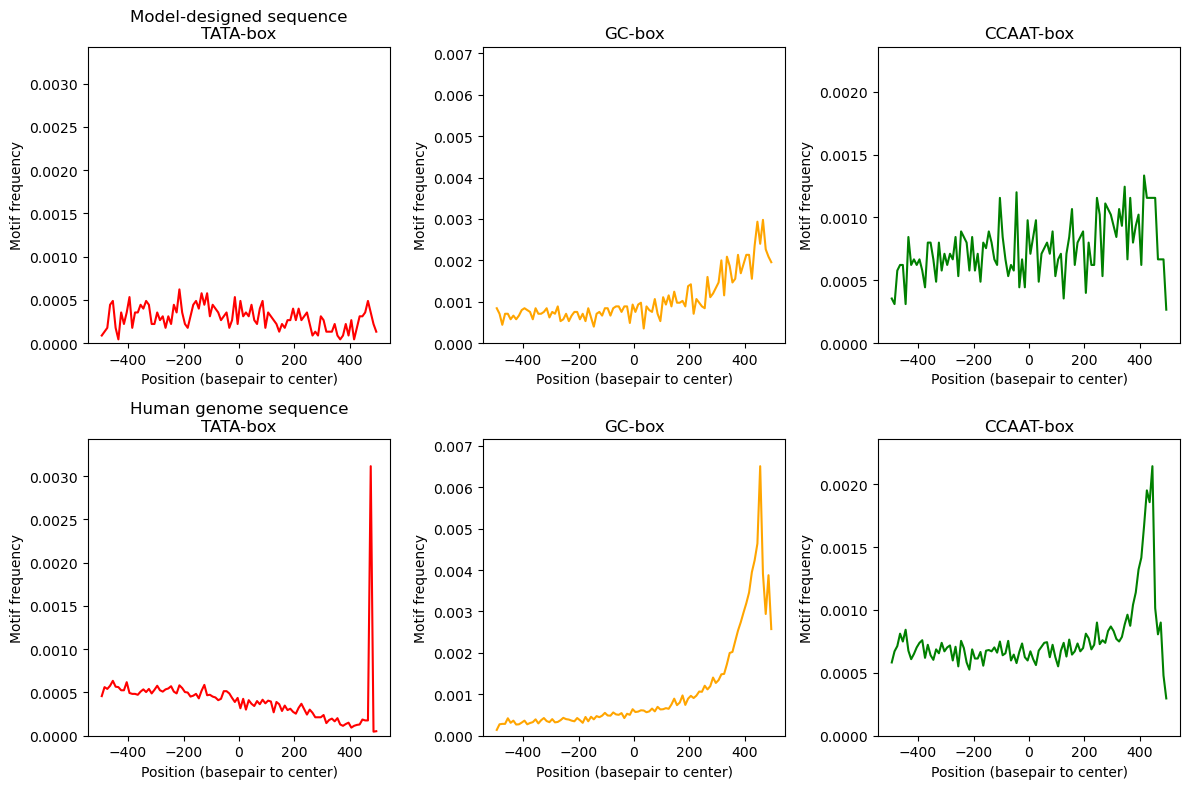

In [40]:
model_motifs, bin_centers = calculate_motif_frequency(seqs)
ref_motifs, _ = calculate_motif_frequency(queries)
fig = plot_motif_frequency(ref_motifs=ref_motifs, model_motifs=model_motifs, bin_centers=bin_centers)
plt.show()

In [41]:
# compute the mean delta
for motif in model_motifs:
    print(motif, np.abs((model_motifs[motif] - ref_motifs[motif])).mean())


TATA-box 0.00016958851674641148
GC-box 0.0004533623650694589
CCAAT-box 0.0001929128816771838


In [14]:
"""
Calculate Fréchet Persistence Distance (FPD) between two sets of DNA sequences.

This script adapts the FPD metric typically used for images to DNA sequences by:
1. Extracting sequence features using k-mer frequency and sequence properties
2. Computing the mean and covariance of these features
3. Calculating the Fréchet distance between distributions

"""

from Bio import SeqIO
import scipy.linalg
from collections import Counter
import os


def get_kmers(sequence, k):
    """Extract all k-mers from a sequence."""
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
def _generate_all_kmers(alphabet, k, prefix=""):
    """Generate all possible k-mers from the given alphabet."""
    if k == 0:
        return [prefix]
    result = []
    for letter in alphabet:
        result.extend(_generate_all_kmers(alphabet, k-1, prefix + letter))
    return result
    
def extract_features(sequences, kmer_size=3):
    """
    Extract features from DNA sequences, similar to how Inception features are extracted from images.
    Features include:
    - k-mer frequencies (normalized)
    - Sequence length
    - GC content
    - Dinucleotide frequencies
    """
    # Generate all possible k-mers
    nucleotides = ['A', 'C', 'G', 'T']
    all_possible_kmers = [''.join(p) for p in _generate_all_kmers(nucleotides, kmer_size)]
    kmer_indices = {kmer: i for i, kmer in enumerate(all_possible_kmers)}
    
    # Initialize feature matrix
    num_kmer_features = len(all_possible_kmers)
    num_additional_features = 6  # length, GC content, 4 dinucleotide properties
    feature_dim = num_kmer_features + num_additional_features
    features = np.zeros((len(sequences), feature_dim))
    
    for i, seq in enumerate(sequences):
        # if i % 1000 == 0 and i > 0:
            # print(f"Processed {i} sequences")
        
        # Extract k-mer frequencies
        kmers = get_kmers(seq, kmer_size)
        kmer_counts = Counter(kmers)
        
        # Normalize k-mer counts
        total_kmers = len(kmers)
        if total_kmers > 0:  # Prevent division by zero
            for kmer in kmer_counts:
                if kmer in kmer_indices:  # Only count valid k-mers
                    features[i, kmer_indices[kmer]] = kmer_counts[kmer] / total_kmers
        
        # Calculate additional features
        features[i, -6] = len(seq) / 1000.0  # Normalized sequence length
        features[i, -5] = (seq.count('G') + seq.count('C')) / len(seq) if len(seq) > 0 else 0  # GC content
        
        # Add dinucleotide properties (simplified representation)
        dinucleotide_counts = Counter(_get_dinucleotides(seq))
        total_dinucleotides = sum(dinucleotide_counts.values())
        if total_dinucleotides > 0:
            features[i, -4] = dinucleotide_counts.get('CG', 0) / total_dinucleotides  # CpG frequency
            features[i, -3] = dinucleotide_counts.get('TA', 0) / total_dinucleotides  # TA frequency
            features[i, -2] = dinucleotide_counts.get('AT', 0) / total_dinucleotides  # AT frequency
            features[i, -1] = dinucleotide_counts.get('GC', 0) / total_dinucleotides  # GC frequency
    
    # print(f"Extracted {feature_dim} features from {len(sequences)} sequences")
    return features

def _generate_all_kmers(alphabet, k, prefix=""):
    """Generate all possible k-mers from the given alphabet."""
    if k == 0:
        return [prefix]
    result = []
    for letter in alphabet:
        result.extend(_generate_all_kmers(alphabet, k-1, prefix + letter))
    return result

def _get_dinucleotides(sequence):
    """Extract all dinucleotides from a sequence."""
    return [sequence[i:i+2] for i in range(len(sequence) - 1)]

def calculate_statistics(features):
    """Calculate mean and covariance matrix for features."""
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    """Calculate Fréchet distance between two distributions."""
    try:
        # Calculate sqrt of product of covariance matrices
        covmean, _ = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        
        # Check if calculation resulted in complex numbers
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        
        # Calculate Fréchet distance
        distance = np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)
        return distance
    except Exception as e:
        # Alternative calculation method for numerical stability
        print("Trying alternative FPD calculation method")
        try:
            diff = mu1 - mu2
            covmean, _ = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
            if np.iscomplexobj(covmean):
                covmean = covmean.real
            distance = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
            return distance
        except Exception as e2:
            print(f"Alternative method also failed: {e2}")
            raise


# Extract features
kmer_size = 3
print("Extracting features from real sequences...")
real_features = extract_features(queries, kmer_size)
print("Extracting features from generated sequences...")
generated_features = extract_features(seqs, kmer_size)

# Calculate statistics
print("Calculating statistics...")
mu_real, sigma_real = calculate_statistics(real_features)
mu_generated, sigma_generated = calculate_statistics(generated_features)

# Calculate FPD
print("Calculating Fréchet Persistence Distance...")
fpd = calculate_frechet_distance(mu_real, sigma_real, mu_generated, sigma_generated)

print(f"\nFréchet Persistence Distance (FPD): {fpd:.4f}")
print(f"Final FPD score: {fpd:.4f}")

# Additional information
print("\nInterpretation:")
print("- Lower FPD scores indicate generated sequences more similar to real sequences")
print("- Higher FPD scores indicate larger differences between distributions")
print("- A perfect score would be 0 (identical distributions)")

Extracting features from real sequences...
Extracting features from generated sequences...
Calculating statistics...
Calculating Fréchet Persistence Distance...

Fréchet Persistence Distance (FPD): 0.0081
Final FPD score: 0.0081

Interpretation:
- Lower FPD scores indicate generated sequences more similar to real sequences
- Higher FPD scores indicate larger differences between distributions
- A perfect score would be 0 (identical distributions)


In [42]:
"""
K-mer range version
Calculate Fréchet Persistence Distance (FPD) between two sets of DNA sequences.

This script adapts the FPD metric typically used for images to DNA sequences by:
1. Extracting sequence features using multiple k-mer sizes, frequencies, and sequence properties
2. Computing the mean and covariance of these features
3. Calculating the Fréchet distance between distributions

"""

from Bio import SeqIO
import numpy as np
import scipy.linalg
from collections import Counter
import os


def get_kmers(sequence, k):
    """Extract all k-mers from a sequence."""
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def _generate_all_kmers(alphabet, k, prefix=""):
    """Generate all possible k-mers from the given alphabet."""
    if k == 0:
        return [prefix]
    result = []
    for letter in alphabet:
        result.extend(_generate_all_kmers(alphabet, k-1, prefix + letter))
    return result
    
def extract_features(sequences, kmer_sizes=[2, 3, 4]):
    """
    Extract features from DNA sequences using multiple k-mer sizes.
    Features include:
    - k-mer frequencies (normalized) for each k-mer size
    - Sequence length
    - GC content
    - Dinucleotide frequencies
    """
    nucleotides = ['A', 'C', 'G', 'T']
    
    # Generate all possible k-mers for each size
    all_kmers_by_size = {}
    kmer_indices_by_size = {}
    total_kmer_features = 0
    
    for k in kmer_sizes:
        all_possible_kmers = _generate_all_kmers(nucleotides, k)
        all_kmers_by_size[k] = all_possible_kmers
        kmer_indices_by_size[k] = {kmer: i + total_kmer_features for i, kmer in enumerate(all_possible_kmers)}
        total_kmer_features += len(all_possible_kmers)
    
    # Initialize feature matrix
    num_additional_features = 6  # length, GC content, 4 dinucleotide properties
    feature_dim = total_kmer_features + num_additional_features
    features = np.zeros((len(sequences), feature_dim))
    
    print(f"Feature dimensions: {total_kmer_features} k-mer features + {num_additional_features} additional = {feature_dim} total")
    
    for i, seq in enumerate(sequences):
        # if i % 1000 == 0 and i > 0:
            # print(f"Processed {i} sequences")
        
        # Extract k-mer frequencies for each k-mer size
        for k in kmer_sizes:
            if len(seq) >= k:  # Only process if sequence is long enough
                kmers = get_kmers(seq, k)
                kmer_counts = Counter(kmers)
                
                # Normalize k-mer counts
                total_kmers = len(kmers)
                if total_kmers > 0:
                    for kmer in kmer_counts:
                        if kmer in kmer_indices_by_size[k]:  # Only count valid k-mers
                            features[i, kmer_indices_by_size[k][kmer]] = kmer_counts[kmer] / total_kmers
        
        # Calculate additional features
        seq_len = len(seq)
        features[i, -6] = seq_len / 1000.0  # Normalized sequence length
        features[i, -5] = (seq.count('G') + seq.count('C')) / seq_len if seq_len > 0 else 0  # GC content
        
        # Add dinucleotide properties
        if seq_len > 1:
            dinucleotides = _get_dinucleotides(seq)
            dinucleotide_counts = Counter(dinucleotides)
            total_dinucleotides = len(dinucleotides)
            
            if total_dinucleotides > 0:
                features[i, -4] = dinucleotide_counts.get('CG', 0) / total_dinucleotides  # CpG frequency
                features[i, -3] = dinucleotide_counts.get('TA', 0) / total_dinucleotides  # TA frequency
                features[i, -2] = dinucleotide_counts.get('AT', 0) / total_dinucleotides  # AT frequency
                features[i, -1] = dinucleotide_counts.get('GC', 0) / total_dinucleotides  # GC frequency
    
    print(f"Extracted {feature_dim} features from {len(sequences)} sequences")
    return features

def _get_dinucleotides(sequence):
    """Extract all dinucleotides from a sequence."""
    return [sequence[i:i+2] for i in range(len(sequence) - 1)]

def calculate_statistics(features):
    """Calculate mean and covariance matrix for features."""
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    
    # Add regularization to prevent singular covariance matrices
    regularization = 1e-6
    if sigma.ndim == 2:
        sigma += regularization * np.eye(sigma.shape[0])
    
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    """Calculate Fréchet distance between two distributions."""
    try:
        # Calculate sqrt of product of covariance matrices
        covmean, _ = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        
        # Check if calculation resulted in complex numbers
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        
        # Calculate Fréchet distance
        distance = np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)
        return distance
    except Exception as e:
        print(f"Standard FPD calculation failed: {e}")
        # Alternative calculation method for numerical stability
        print("Trying alternative FPD calculation method")
        try:
            diff = mu1 - mu2
            covmean, _ = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
            if np.iscomplexobj(covmean):
                covmean = covmean.real
            distance = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
            return distance
        except Exception as e2:
            print(f"Alternative method also failed: {e2}")
            # Final fallback: simplified distance calculation
            print("Using simplified distance calculation")
            diff = mu1 - mu2
            distance = np.sum(diff ** 2) + np.trace(sigma1) + np.trace(sigma2)
            return distance

def calculate_fpd_multi_kmer(queries, seqs, kmer_sizes=[2, 3, 4]):
    """
    Calculate FPD using multiple k-mer sizes.
    
    Args:
        queries: List of real DNA sequences
        seqs: List of generated DNA sequences  
        kmer_sizes: List of k-mer sizes to use (default: [2, 3, 4])
    
    Returns:
        float: FPD score
    """
    print(f"Using k-mer sizes: {kmer_sizes}")
    
    # Extract features
    print("Extracting features from real sequences...")
    real_features = extract_features(queries, kmer_sizes)
    print("Extracting features from generated sequences...")
    generated_features = extract_features(seqs, kmer_sizes)

    # Calculate statistics
    print("Calculating statistics...")
    mu_real, sigma_real = calculate_statistics(real_features)
    mu_generated, sigma_generated = calculate_statistics(generated_features)

    # Calculate FPD
    print("Calculating Fréchet Persistence Distance...")
    fpd = calculate_frechet_distance(mu_real, sigma_real, mu_generated, sigma_generated)

    return fpd

# Extract features
kmer_sizes = range(3, 7)  # k-mer sizes from 3 to 6
print("Extracting features from real sequences...")
real_features = extract_features(queries, kmer_sizes)
print("Extracting features from generated sequences...")
generated_features = extract_features(seqs, kmer_sizes)

# Calculate statistics
print("Calculating statistics...")
mu_real, sigma_real = calculate_statistics(real_features)
mu_generated, sigma_generated = calculate_statistics(generated_features)

# Calculate FPD
print("Calculating Fréchet Persistence Distance...")
fpd = calculate_frechet_distance(mu_real, sigma_real, mu_generated, sigma_generated)

print(f"\nFréchet Persistence Distance (FPD): {fpd:.4f}")
print(f"Final FPD score: {fpd:.4f}")

# Additional information
print("\nInterpretation:")
print("- Lower FPD scores indicate generated sequences more similar to real sequences")
print("- Higher FPD scores indicate larger differences between distributions")
print("- A perfect score would be 0 (identical distributions)")

Extracting features from real sequences...
Feature dimensions: 5440 k-mer features + 6 additional = 5446 total
Extracted 5446 features from 19228 sequences
Extracting features from generated sequences...
Feature dimensions: 5440 k-mer features + 6 additional = 5446 total
Extracted 5446 features from 2661 sequences
Calculating statistics...
Calculating Fréchet Persistence Distance...

Fréchet Persistence Distance (FPD): 0.2350
Final FPD score: 0.2350

Interpretation:
- Lower FPD scores indicate generated sequences more similar to real sequences
- Higher FPD scores indicate larger differences between distributions
- A perfect score would be 0 (identical distributions)
